# Lab 5 Data Science
## Análisis de Sentimientos.
---
1. Jorge Perez - 18364
2. Diego Ruiz - 18761

In [123]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import sklearn.cluster as cluster
import sklearn.metrics as metrics
import sklearn.preprocessing
import scipy.cluster.hierarchy as sch
import skfuzzy as fuzz
import numpy as np
import pylab
import sklearn.mixture as mixture
import random
from itertools import permutations
from seaborn import heatmap, countplot

import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from collections import Counter
from wordcloud import WordCloud


%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

In [124]:
df = pd.read_csv('data/train.csv')
dfTest = pd.read_csv('data/test.csv')

df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [125]:
df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [126]:
df.shape

(7613, 5)

<Axes: >

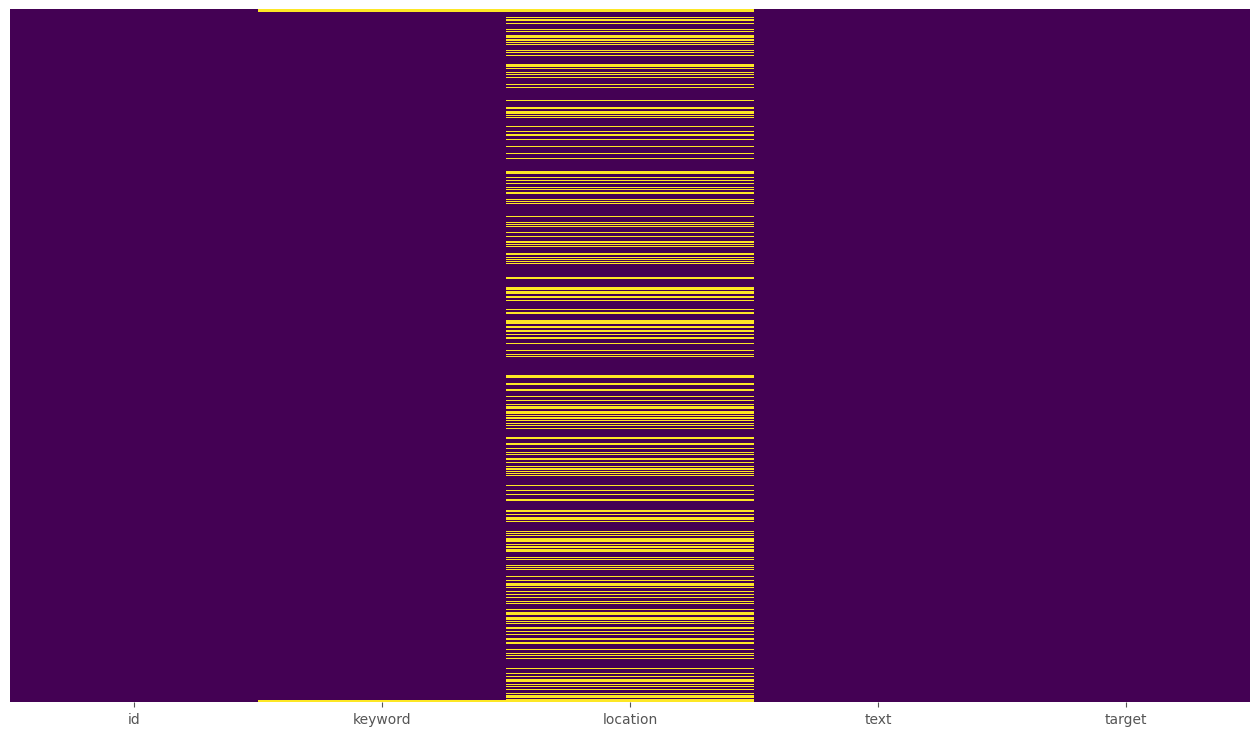

In [127]:
heatmap(df.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')

In [128]:
from scipy.stats import chi2_contingency


def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

columns = df.columns
corr_matrix = [[] for i in range(len(columns))]

for i in range(len(columns)):
    for j in range(len(columns)):
        corr_matrix[i].append(cramers_v(df[columns[i]], df[columns[j]]))

C:\Users\yeyoc\AppData\Local\Temp\ipykernel_520\3346907167.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))
C:\Users\yeyoc\AppData\Local\Temp\ipykernel_520\3346907167.py:13: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))
C:\Users\yeyoc\AppData\Local\Temp\ipykernel_520\3346907167.py:13: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))
C:\Users\yeyoc\AppData\Local\Temp\ipykernel_520\3346907167.py:13: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))
C:\Users\yeyoc\AppData\Local\Temp\ipykernel_520\3346907167.py:13: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))
C:\Users\yeyoc\AppData\Local\Temp\ipykernel_520\3346907167.py:13: RuntimeWarnin

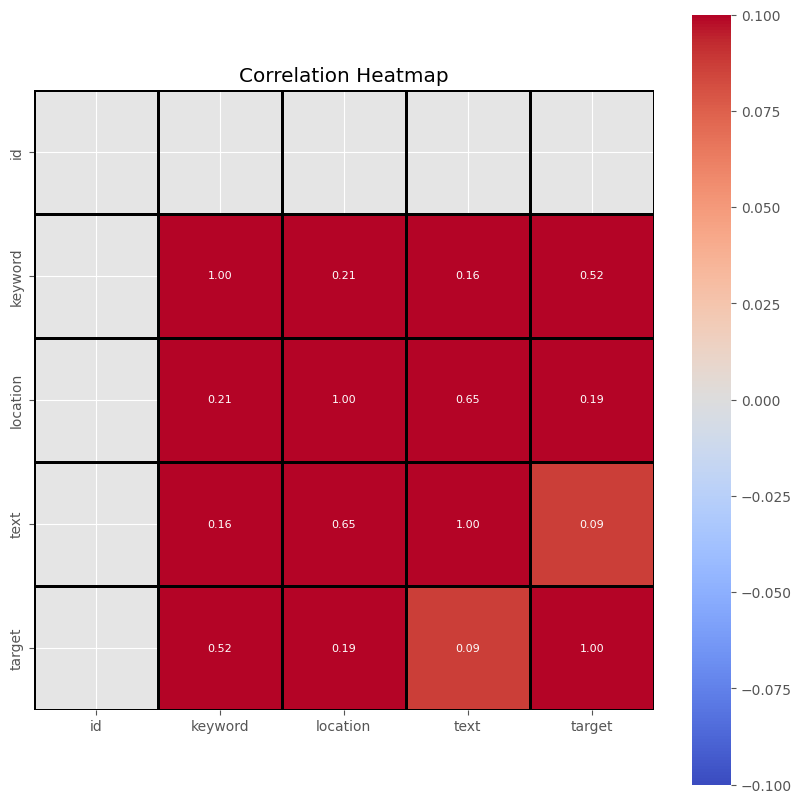

In [129]:
corr_df = pd.DataFrame(corr_matrix, index=columns, columns=columns)

plt.figure(figsize=(10, 10))
heatmap(corr_df,annot=True, annot_kws={"size": 8}, cmap='coolwarm', fmt=".2f", linecolor="black",linewidths=1,square=True)
plt.title("Correlation Heatmap")
plt.show()

In [130]:
unique_values = df[['id']].nunique()
print(unique_values)
unique_niveles = df['id'].unique()
print("Sectores únicos:", unique_niveles)

id    7613
dtype: int64
Sectores únicos: [    1     4     5 ... 10871 10872 10873]


In [131]:
df = df.drop(columns=['id'])

In [132]:
unique_values = df[['keyword']].nunique()
print(unique_values)
unique_niveles = df['keyword'].unique()
print("Sectores únicos:", unique_niveles)

keyword    221
dtype: int64
Sectores únicos: [nan 'ablaze' 'accident' 'aftershock' 'airplane%20accident' 'ambulance'
 'annihilated' 'annihilation' 'apocalypse' 'armageddon' 'army' 'arson'
 'arsonist' 'attack' 'attacked' 'avalanche' 'battle' 'bioterror'
 'bioterrorism' 'blaze' 'blazing' 'bleeding' 'blew%20up' 'blight'
 'blizzard' 'blood' 'bloody' 'blown%20up' 'body%20bag' 'body%20bagging'
 'body%20bags' 'bomb' 'bombed' 'bombing' 'bridge%20collapse'
 'buildings%20burning' 'buildings%20on%20fire' 'burned' 'burning'
 'burning%20buildings' 'bush%20fires' 'casualties' 'casualty'
 'catastrophe' 'catastrophic' 'chemical%20emergency' 'cliff%20fall'
 'collapse' 'collapsed' 'collide' 'collided' 'collision' 'crash' 'crashed'
 'crush' 'crushed' 'curfew' 'cyclone' 'damage' 'danger' 'dead' 'death'
 'deaths' 'debris' 'deluge' 'deluged' 'demolish' 'demolished' 'demolition'
 'derail' 'derailed' 'derailment' 'desolate' 'desolation' 'destroy'
 'destroyed' 'destruction' 'detonate' 'detonation' 'devastated'

In [133]:
unique_values = df[['location']].nunique()
print(unique_values)
unique_niveles = df['location'].unique()
print("Sectores únicos:", unique_niveles)

location    3341
dtype: int64
Sectores únicos: [nan 'Birmingham' 'Est. September 2012 - Bristol' ... 'Vancouver, Canada'
 'London ' 'Lincoln']


In [134]:
unique_values = df[['text']].nunique()
print(unique_values)
unique_niveles = df['text'].unique()
print("Sectores únicos:", unique_niveles)

text    7503
dtype: int64
Sectores únicos: ['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'
 'Forest fire near La Ronge Sask. Canada'
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"
 ...
 'Suicide bomber kills 15 in Saudi security site mosque - Reuters via World - Google News - Wall ... http://t.co/nF4IculOje'
 'Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5'
 'The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d']


In [135]:
unique_values = df[['target']].nunique()
print(unique_values)
unique_niveles = df['target'].unique()
print("Sectores únicos:", unique_niveles)

target    2
dtype: int64
Sectores únicos: [1 0]


## Limpieza y Procesamiento

Primero, se convierte el texto a minusculas.

In [136]:
df['text'] = df['text'].str.lower()

df.head()

,keyword,location,text,target
0,NaN,NaN,our deeds are the reason of this #earthquake m...,1
1,NaN,NaN,forest fire near la ronge sask. canada,1
2,NaN,NaN,all residents asked to 'shelter in place' are ...,1
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,NaN,just got sent this photo from ruby #alaska as ...,1


Se eliminan datos duplicados de existir

In [137]:
df.drop_duplicates()

,keyword,location,text,target
0,NaN,NaN,our deeds are the reason of this #earthquake m...,1
1,NaN,NaN,forest fire near la ronge sask. canada,1
2,NaN,NaN,all residents asked to 'shelter in place' are ...,1
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,NaN,just got sent this photo from ruby #alaska as ...,1
...,...,...,...,...
7608,NaN,NaN,two giant cranes holding a bridge collapse int...,1
7609,NaN,NaN,@aria_ahrary @thetawniest the out of control w...,1
7610,NaN,NaN,m1.94 [01:04 utc]?5km s of volcano hawaii. htt...,1
7611,NaN,NaN,police investigating after an e-bike collided ...,1


Quitar los caracteres especiales que aparecen como “#”,”@” o los apóstrofes.

In [138]:
def caracteres_especiales(text):
    text = re.sub(r"[#@'/-]", "", text)
    return text
df['text'] = df['text'].apply(caracteres_especiales)

df

,keyword,location,text,target
0,NaN,NaN,our deeds are the reason of this earthquake ma...,1
1,NaN,NaN,forest fire near la ronge sask. canada,1
2,NaN,NaN,all residents asked to shelter in place are be...,1
3,NaN,NaN,"13,000 people receive wildfires evacuation ord...",1
4,NaN,NaN,just got sent this photo from ruby alaska as s...,1
...,...,...,...,...
7608,NaN,NaN,two giant cranes holding a bridge collapse int...,1
7609,NaN,NaN,aria_ahrary thetawniest the out of control wil...,1
7610,NaN,NaN,m1.94 [01:04 utc]?5km s of volcano hawaii. htt...,1
7611,NaN,NaN,police investigating after an ebike collided w...,1


Quitar las url.

In [139]:
def urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)
df['text'] = df['text'].apply(urls)

df

,keyword,location,text,target
0,NaN,NaN,our deeds are the reason of this earthquake ma...,1
1,NaN,NaN,forest fire near la ronge sask. canada,1
2,NaN,NaN,all residents asked to shelter in place are be...,1
3,NaN,NaN,"13,000 people receive wildfires evacuation ord...",1
4,NaN,NaN,just got sent this photo from ruby alaska as s...,1
...,...,...,...,...
7608,NaN,NaN,two giant cranes holding a bridge collapse int...,1
7609,NaN,NaN,aria_ahrary thetawniest the out of control wil...,1
7610,NaN,NaN,m1.94 [01:04 utc]?5km s of volcano hawaii. htt...,1
7611,NaN,NaN,police investigating after an ebike collided w...,1


Revisar si hay emoticones y quitarlos.

In [140]:
emoji_pattern = re.compile("[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251]+")
df['text'] = df['text'].apply(lambda text: emoji_pattern.sub(r'', text))

df

,keyword,location,text,target
0,NaN,NaN,our deeds are the reason of this earthquake ma...,1
1,NaN,NaN,forest fire near la ronge sask. canada,1
2,NaN,NaN,all residents asked to shelter in place are be...,1
3,NaN,NaN,"13,000 people receive wildfires evacuation ord...",1
4,NaN,NaN,just got sent this photo from ruby alaska as s...,1
...,...,...,...,...
7608,NaN,NaN,two giant cranes holding a bridge collapse int...,1
7609,NaN,NaN,aria_ahrary thetawniest the out of control wil...,1
7610,NaN,NaN,m1.94 [01:04 utc]?5km s of volcano hawaii. htt...,1
7611,NaN,NaN,police investigating after an ebike collided w...,1


Quitar los signos de puntuación.

In [141]:
punctuation_pattern = re.compile(r'[^\w\s]')
df['text'] = df['text'].apply(lambda text: punctuation_pattern.sub('', text))

df

,keyword,location,text,target
0,NaN,NaN,our deeds are the reason of this earthquake ma...,1
1,NaN,NaN,forest fire near la ronge sask canada,1
2,NaN,NaN,all residents asked to shelter in place are be...,1
3,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,NaN,NaN,just got sent this photo from ruby alaska as s...,1
...,...,...,...,...
7608,NaN,NaN,two giant cranes holding a bridge collapse int...,1
7609,NaN,NaN,aria_ahrary thetawniest the out of control wil...,1
7610,NaN,NaN,m194 0104 utc5km s of volcano hawaii httptcozd...,1
7611,NaN,NaN,police investigating after an ebike collided w...,1


Quitar los artículos, preposiciones y conjunciones (stopwords).

In [142]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [143]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

df['text'] = df['text'].apply(stopwords)
df.dropna(inplace=True)

df

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yeyoc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,keyword,location,text,target
31,ablaze,Birmingham,bbcmtd wholesale markets ablaze httptcolhyxeohy6c,1
32,ablaze,Est. September 2012 - Bristol,always try bring heavy metal rt httptcoyao1e0xngw,0
33,ablaze,AFRICA,africanbaze breaking newsnigeria flag set abla...,1
34,ablaze,"Philadelphia, PA",crying set ablaze,0
35,ablaze,"London, UK",plus side look sky last night ablaze httptcoqq...,0
...,...,...,...,...
7575,wrecked,TN,bright side wrecked httptcouea0txrhys,0
7577,wrecked,#NewcastleuponTyne #UK,widda16 hes gone relax thought wife wrecked ca...,0
7579,wrecked,"Vancouver, Canada",three days work theyve pretty much wrecked hah...,0
7580,wrecked,London,fx forex trading cramer igers 3 words wrecked ...,0


Quitar números si considera que interferirán en la clasificación (Se decidio no quitar el 911).

In [144]:
def remove_numbers_except_911(text):
    def stopwords(text):
        words = text.split()
        filtered_words = [word for word in words if word.lower() not in stop_words or word == "911"]
        return ' '.join(filtered_words)
    
    text_without_numbers = re.sub(r'\b\d+\b', '', text)
    text_without_numbers = stopwords(text_without_numbers)  # Remove stopwords
    
    return text_without_numbers

df['text'] = df['text'].apply(remove_numbers_except_911)

df.dropna(inplace=True)

df

,keyword,location,text,target
31,ablaze,Birmingham,bbcmtd wholesale markets ablaze httptcolhyxeohy6c,1
32,ablaze,Est. September 2012 - Bristol,always try bring heavy metal rt httptcoyao1e0xngw,0
33,ablaze,AFRICA,africanbaze breaking newsnigeria flag set abla...,1
34,ablaze,"Philadelphia, PA",crying set ablaze,0
35,ablaze,"London, UK",plus side look sky last night ablaze httptcoqq...,0
...,...,...,...,...
7575,wrecked,TN,bright side wrecked httptcouea0txrhys,0
7577,wrecked,#NewcastleuponTyne #UK,widda16 hes gone relax thought wife wrecked ca...,0
7579,wrecked,"Vancouver, Canada",three days work theyve pretty much wrecked hah...,0
7580,wrecked,London,fx forex trading cramer igers words wrecked di...,0


Obtenga la frecuencia de las palabras tanto de los tweets de desastres como de los que no. ¿Qué
palabras cree que le servirán para hacer un mejor modelo de clasificación?¿vale la pena explorar
bigramas o trigramas para analizar contexto?

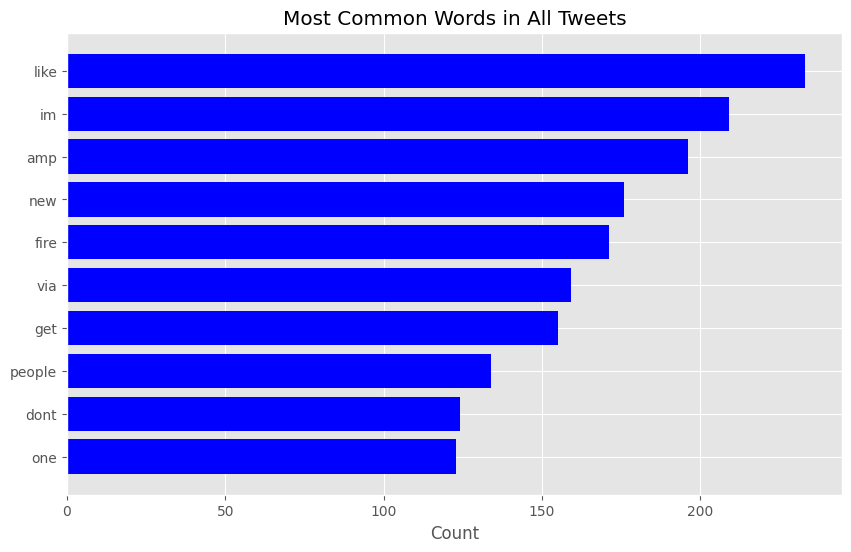

In [145]:
# Preprocess the text without removing stopwords
def preprocess_text_no_stopwords(text):
    text = text.lower()
    # Caracteres especiales y urls
    text = re.sub(r"[#@\'/-]", "", text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    return text

df['processed_text'] = df['text'].apply(preprocess_text_no_stopwords)

all_words = ' '.join(df['processed_text']).split()
common_words_all = Counter(all_words).most_common(10)

common_words_all

words, counts = zip(*common_words_all)

plt.figure(figsize=(10, 6))
plt.barh(words, counts, color='blue')
plt.xlabel('Count')
plt.title('Most Common Words in All Tweets')
plt.gca().invert_yaxis()
plt.show()

No se considera que sea necesario explorar
bigramas o trigramas para analizar contexto.

Haga un análisis exploratorio de los datos para entenderlos mejor, documente todos los análisis. Investigar qué palabra se repite más en cada una de las categorías.

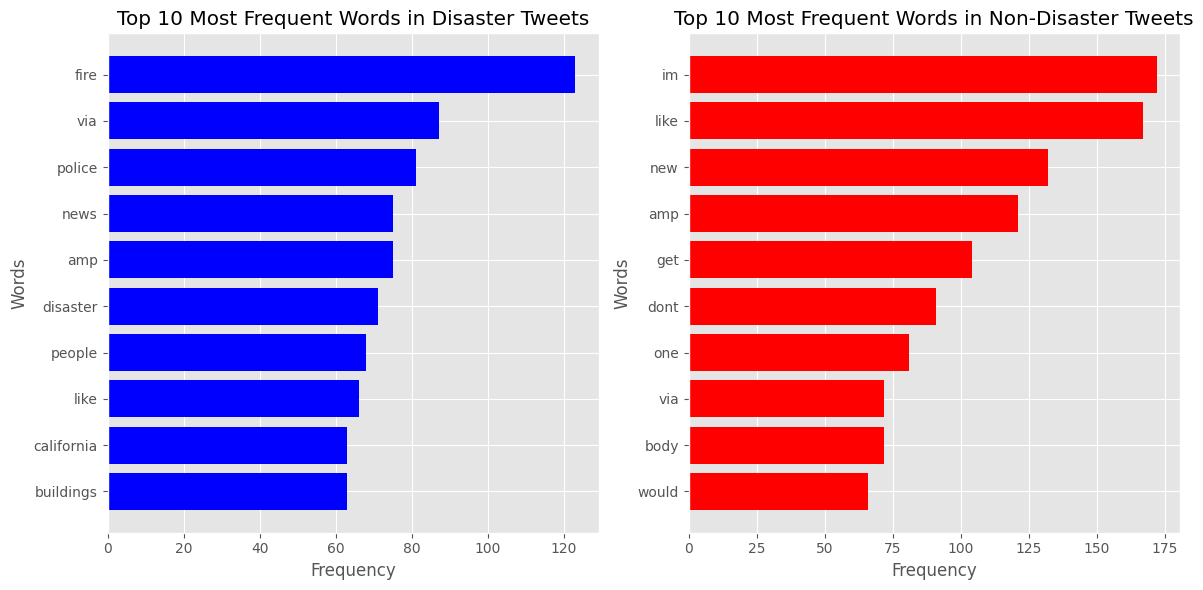

In [146]:
disaster_tweets = df[df['target'] == 1]['text']
non_disaster_tweets = df[df['target'] == 0]['text']

# Obtiene la frecuencia de las palabras
disaster_word_freq = Counter(" ".join(disaster_tweets).split())
non_disaster_word_freq = Counter(" ".join(non_disaster_tweets).split())

# Get the top 10 most common words and their counts
disaster_common_words = disaster_word_freq.most_common(10)[::-1]
non_disaster_common_words = non_disaster_word_freq.most_common(10)[::-1]

# Unpack the common words and their counts
disaster_words, disaster_counts = zip(*disaster_common_words)
non_disaster_words, non_disaster_counts = zip(*non_disaster_common_words)

# Create subplots for visualizing the top words
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Bar plot for disaster tweets
axes[0].barh(disaster_words, disaster_counts, color='blue')
axes[0].set_title('Top 10 Most Frequent Words in Disaster Tweets')
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Words')

# Bar plot for non-disaster tweets
axes[1].barh(non_disaster_words, non_disaster_counts, color='red')
axes[1].set_title('Top 10 Most Frequent Words in Non-Disaster Tweets')
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('Words')

# Adjust layout for better visibility of both plots
plt.tight_layout()

# Show the plots
plt.show()


Nube de palabras para visualizar las que aparecen con más frecuencia

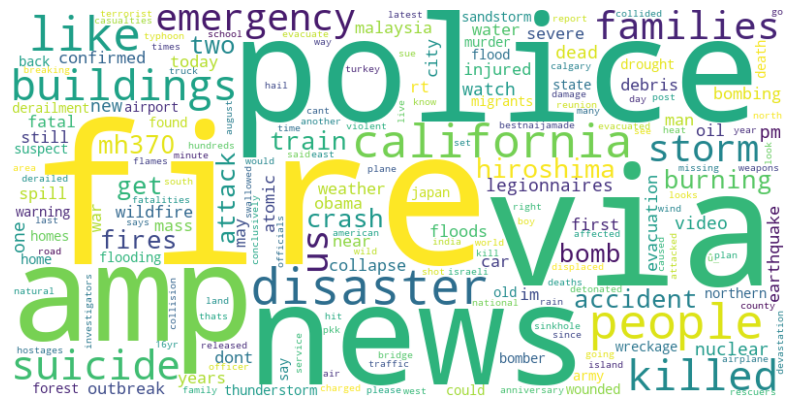

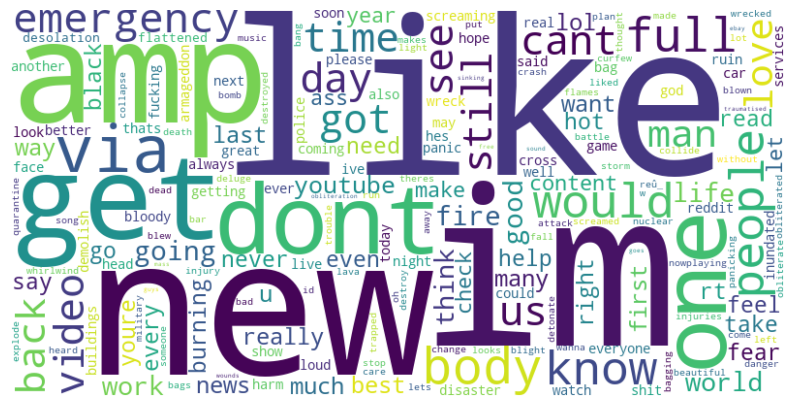

In [147]:
def create_word_cloud(word_freq):
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(word_freq)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Creamos una nube de palabras para los tweets de desastres
create_word_cloud(disaster_word_freq)

# Creamos una nube de palabras para los tweets que no son de desastres
create_word_cloud(non_disaster_word_freq)

Es interesante las palabras que tienen precencia en ambas categorias como im o like o amp que nos muestran que no es necesariamente que sean palabras de desastre necesariamente ya que importa mucho el contexto en que se usen.

## Algoritmo de Clasificacion

In [148]:
# Vectorize the text
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['processed_text'])
y = df['target']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a logistic regression model
clf_lr = LogisticRegression(max_iter=1000, random_state=42)
clf_lr.fit(X_train, y_train)

# Train a Naive Bayes model
clf_nb = MultinomialNB()
clf_nb.fit(X_train, y_train)

# Train an SVM model
clf_svm = SVC()
clf_svm.fit(X_train, y_train)

# Evaluate the models
def evaluate_model(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)
    return accuracy, classification_rep

In [149]:
# Evaluate Logistic Regression
accuracy_lr, classification_rep_lr = evaluate_model(clf_lr, X_test, y_test)
print("Logistic Regression:")
print("Accuracy:", accuracy_lr)
print(classification_rep_lr)
print()

Logistic Regression:
Accuracy: 0.7933070866141733
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       580
           1       0.80      0.69      0.74       436

    accuracy                           0.79      1016
   macro avg       0.79      0.78      0.78      1016
weighted avg       0.79      0.79      0.79      1016




In [150]:
# Evaluate Naive Bayes
accuracy_nb, classification_rep_nb = evaluate_model(clf_nb, X_test, y_test)
print("Naive Bayes:")
print("Accuracy:", accuracy_nb)
print(classification_rep_nb)
print()

Naive Bayes:
Accuracy: 0.8090551181102362
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       580
           1       0.79      0.76      0.77       436

    accuracy                           0.81      1016
   macro avg       0.81      0.80      0.80      1016
weighted avg       0.81      0.81      0.81      1016




In [151]:
# Evaluate SVM
accuracy_svm, classification_rep_svm = evaluate_model(clf_svm, X_test, y_test)
print("Support Vector Machine:")
print("Accuracy:", accuracy_svm)
print(classification_rep_svm)

Support Vector Machine:
Accuracy: 0.7893700787401575
              precision    recall  f1-score   support

           0       0.76      0.92      0.83       580
           1       0.85      0.62      0.72       436

    accuracy                           0.79      1016
   macro avg       0.80      0.77      0.77      1016
weighted avg       0.80      0.79      0.78      1016



Tras probar con varios modelos, se determino que el mejor para predecir en este caso es Naive Bayes que tuvo una accuracy de 80%. De igual forma, todos los algoritmos son muy buenos para esta clasificacion.

Elabore una función en la que el usuario ingrese un tweet y el sistema lo clasifique en desastre
o no.

In [152]:
def classify_tweet(text):
    processed_text = preprocess_text_no_stopwords(text)
    X = vectorizer.transform([processed_text])
    prediction = clf_nb.predict(X)
    return "Disaster Tweet" if prediction == 1 else "Non-Disaster Tweet"

In [153]:
test_tweet = "Just felt an earthquake, it was so strong!"
classify_tweet(test_tweet)

'Disaster Tweet'

In [154]:
test_tweet = "Had a great day at the park with friends"
classify_tweet(test_tweet)

'Non-Disaster Tweet'

In [155]:
test_tweet = "Tornado warning issued for our area"
classify_tweet(test_tweet)

'Disaster Tweet'

In [34]:

test_tweet = "Attending a concert tonight, can't wait!"
classify_tweet(test_tweet)

'Non-Disaster Tweet'

## Análisis de Sentimientos.

Determinar las palabras positivas, negativas o neutras.

In [157]:
from textblob import TextBlob

def analizar_sentimiento(texto):
    analysis = TextBlob(texto)
    if analysis.sentiment.polarity > 0:
        return "positivo"
    elif analysis.sentiment.polarity == 0:
        return "neutral"
    else:
        return "negativo"

df['sentimiento'] = df['text'].apply(analizar_sentimiento)
conteo_sentimientos = df['sentimiento'].value_counts()

conteo_sentimientos


sentimiento
neutral     2448
positivo    1592
negativo    1040
Name: count, dtype: int64

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yeyoc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


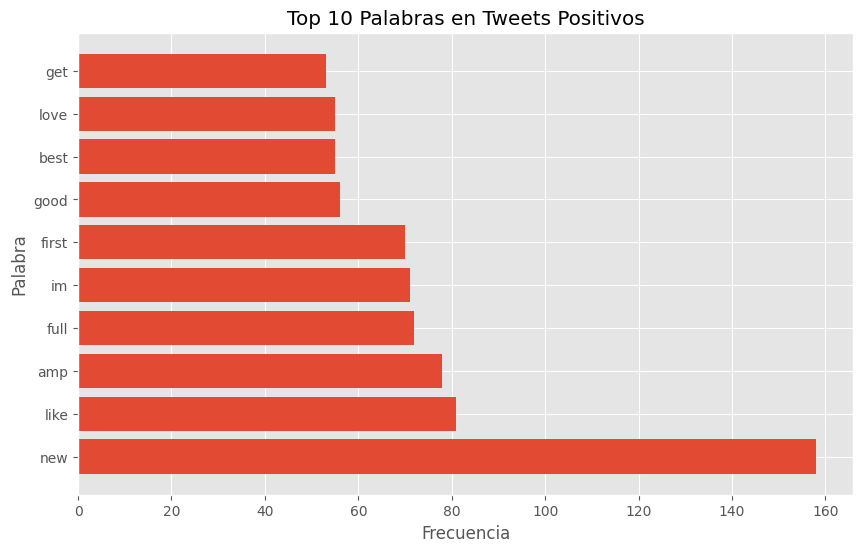

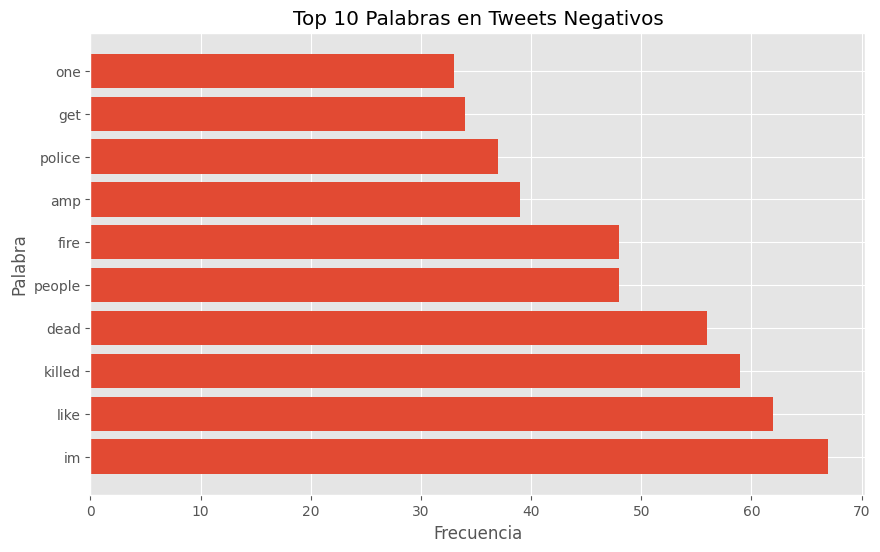

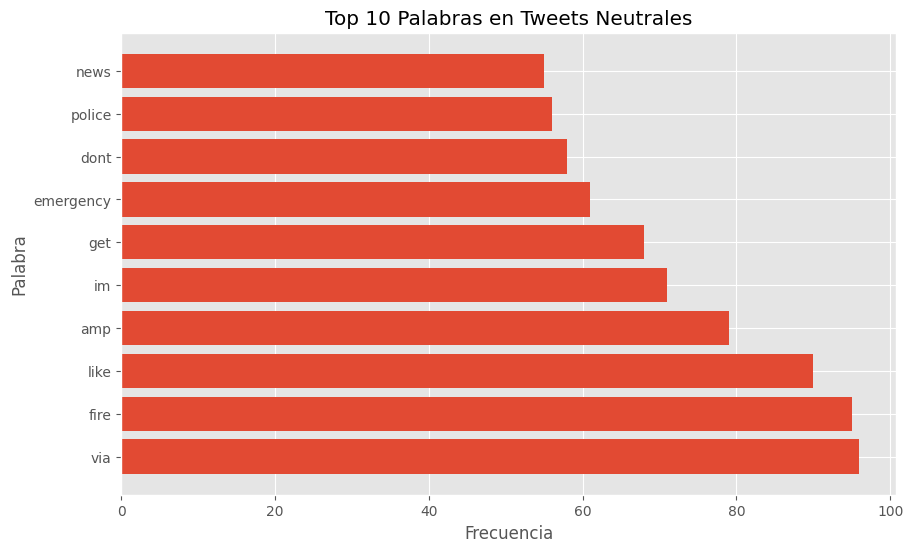

In [159]:
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

nltk.download('punkt')

palabras_positivas = []
palabras_negativas = []
palabras_neutras = []

for index, row in df.iterrows():
    tokens = word_tokenize(row['text'])
    for token in tokens:
        if row['sentimiento'] == 'positivo':
            palabras_positivas.append(token.lower())
        elif row['sentimiento'] == 'negativo':
            palabras_negativas.append(token.lower())
        else:
            palabras_neutras.append(token.lower())

fdist_positivas = FreqDist(palabras_positivas)
fdist_negativas = FreqDist(palabras_negativas)
fdist_neutras = FreqDist(palabras_neutras)

top_10_positivas = fdist_positivas.most_common(10)
top_10_negativas = fdist_negativas.most_common(10)
top_10_neutras = fdist_neutras.most_common(10)

def plot_histogram(top_words, title):
    words, frequencies = zip(*top_words)
    plt.figure(figsize=(10, 6))
    plt.barh(words, frequencies)
    plt.xlabel('Frecuencia')
    plt.ylabel('Palabra')
    plt.title(title)

plot_histogram(top_10_positivas, 'Top 10 Palabras en Tweets Positivos')
plt.show()

plot_histogram(top_10_negativas, 'Top 10 Palabras en Tweets Negativos')
plt.show()

plot_histogram(top_10_neutras, 'Top 10 Palabras en Tweets Neutrales')
plt.show()


Teniendo en cuenta la cantidad de palabras positivas y negativas del tweet determine qué tan
positivo, negativo o neutral es el mismo-

In [161]:
def calcular_polaridad(texto):
    analysis = TextBlob(texto)
    return analysis.sentiment.polarity

df['polaridad'] = df['text'].apply(calcular_polaridad)

def etiquetar_sentimiento(polaridad):
    if polaridad > 0:
        return "positivo"
    elif polaridad < 0:
        return "negativo"
    else:
        return "neutral"

df['sentimiento'] = df['polaridad'].apply(etiquetar_sentimiento)

print(df[['text', 'sentimiento']])

                                                   text sentimiento
31    bbcmtd wholesale markets ablaze httptcolhyxeohy6c     neutral
32    always try bring heavy metal rt httptcoyao1e0xngw    negativo
33    africanbaze breaking newsnigeria flag set abla...     neutral
34                                    crying set ablaze    negativo
35    plus side look sky last night ablaze httptcoqq...     neutral
...                                                 ...         ...
7575              bright side wrecked httptcouea0txrhys    positivo
7577  widda16 hes gone relax thought wife wrecked ca...    positivo
7579  three days work theyve pretty much wrecked hah...    positivo
7580  fx forex trading cramer igers words wrecked di...     neutral
7581  engineshed great atmosphere british lion gig t...    positivo

[5080 rows x 2 columns]


7 Luego de analizar los datos determine: <br>
7.1. ¿Cuáles son los 10 tweets más negativos?¿En qué categoría están? <br>
7.2. ¿Cuáles son los 10 tweets más positivos? ¿En qué categoría están? <br>
7.3. ¿Son los tweets de la categoría que indica que habla de un desastre real más negativos que
los de la otra categoría?

In [170]:
def etiquetar_categoria(target):
    return "Disaster Tweet" if target == 1 else "Non-Disaster Tweet"

# Los 10 tweets más negativos con su categoría
top_10_negativos = df.nlargest(10, 'polaridad')
top_10_negativos['categoria'] = top_10_negativos['target'].apply(etiquetar_categoria)
print("Los 10 tweets más negativos:")
print(top_10_negativos[['text', 'categoria']])

# Los 10 tweets más positivos con su categoría
top_10_positivos = df.nsmallest(10, 'polaridad')
top_10_positivos['categoria'] = top_10_positivos['target'].apply(etiquetar_categoria)
print("\nLos 10 tweets más positivos:")
print(top_10_positivos[['text', 'categoria']])


Los 10 tweets más negativos:
                                                   text           categoria
128   remembering going die best way know avoid trap...  Non-Disaster Tweet
413   nowplaying arsonist mc impressed arsonistmusic...  Non-Disaster Tweet
1426  whimsy pertains mass casualties always impressive  Non-Disaster Tweet
2035  therealrittz fettilootch slanglucci oppression...  Non-Disaster Tweet
2040  bluebirddenver fettilootch slanglucci oppressi...      Disaster Tweet
2045  remainontop fettilootch slanglucci oppressions...  Non-Disaster Tweet
2046  nuggets fettilootch slanglucci oppressions gre...  Non-Disaster Tweet
2061  silent0siris even awesome norse landscapes loa...  Non-Disaster Tweet
2217  fifth predynastic king legendary period deluge...  Non-Disaster Tweet
2368  dont let wmata metro derail day get text every...  Non-Disaster Tweet

Los 10 tweets más positivos:
                                                   text           categoria
143   horrible accident man d

In [171]:
polaridad_promedio_desastre_real = df[df['target'] == 1]['polaridad'].mean()

polaridad_promedio_no_desastre_real = df[df['target'] == 0]['polaridad'].mean()

# Comparar
if polaridad_promedio_desastre_real < polaridad_promedio_no_desastre_real:
    print("Los tweets de la categoría de desastre real son más negativos.")
elif polaridad_promedio_desastre_real > polaridad_promedio_no_desastre_real:
    print("Los tweets de la otra categoría son más negativos.")
else:
    print("No hay diferencia significativa en la polaridad promedio entre las categorías.")


Los tweets de la categoría de desastre real son más negativos.


8. Cree una variable que contenga la “negatividad” de cada tweet. Inclúyala en el conjunto de
datos y entrene nuevamente el modelo de clasificación de la hoja pasada. ¿La inclusión de esta
variable mejoró los resultados del modelo de clasificación?

In [222]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['processed_text'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf_lr = LogisticRegression(max_iter=1000, random_state=42)
clf_lr.fit(X_train, y_train)

def evaluate_model(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)
    return accuracy, classification_rep

# Evaluate Logistic Regression
accuracy_lr, classification_rep_lr = evaluate_model(clf_lr, X_test, y_test)
print("Logistic Regression:")
print("Accuracy:", accuracy_lr)
print(classification_rep_lr)
print()

Logistic Regression:
Accuracy: 0.7933070866141733
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       580
           1       0.80      0.69      0.74       436

    accuracy                           0.79      1016
   macro avg       0.79      0.78      0.78      1016
weighted avg       0.79      0.79      0.79      1016




El modelo es un poco menos preciso que el que se entreno la semana pasada sin esta nueva variable de negatividad del tweet. La variacion es muy pequeña, unicamente de 1% por lo que se puede decir que los modelos tienen un rendimiento y una capacidad de clasificacion muy parecidos. Ambos modelos son buenos para este ejercicio pero es interesante saber como la negatividad del tweet puede ser muy ligada y al mismo tiempo ser muy distante a si un tweet es un desastre real o no.